# Modelling Rumors based on the CREDBANK Dataset

The following notebook describes the process of training the Support Vector Classifier to determine if a tweet contains a rumor or not.

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import figure
from sklearn.model_selection import train_test_split
import regex as re
import string
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Extraction

In [4]:
df = pd.read_csv('Final_train_data.csv')

In [5]:
df.head()

,id,is_credible,text
0,5.228430e+17,0,RT @onedirection: The guys are up for 3 #AMAs ...
1,5.252810e+17,0,RT @Marvel: Here it is! Watch the @Avengers: #...
2,5.637530e+17,0,"""This is another PR stunt by ISIS,"" Jordanian ..."
3,5.656020e+17,0,RT @Independent: The media ignored the #Chapel...
4,5.507820e+17,0,RT @rivalsmike: Wow “@JeffPassan: Baylor kicke...


In [6]:
df.dtypes

id             float64
is_credible      int64
text            object
dtype: object

In [7]:
df.shape

(344200, 3)

In [8]:
# Drop any null rows
df.dropna(inplace=True)

In [22]:
df_reduced = df.sample(frac = 0.2)

In [23]:
X = df_reduced['text']
y = df_reduced['is_credible']

In [24]:
# Distribution of is_credible (1=True, 0=False)
y.value_counts(normalize=True)

1    0.707132
0    0.292868
Name: is_credible, dtype: float64

Baseline Accuracy is 70.9%

In [25]:
# Double check there are no null values
X.isnull().sum()

0

In [26]:
y.isnull().sum()

0

## Split Data into Testing & Training

In [27]:
# Create train-test split, 77 training: 33 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Exploratory Data Analysis

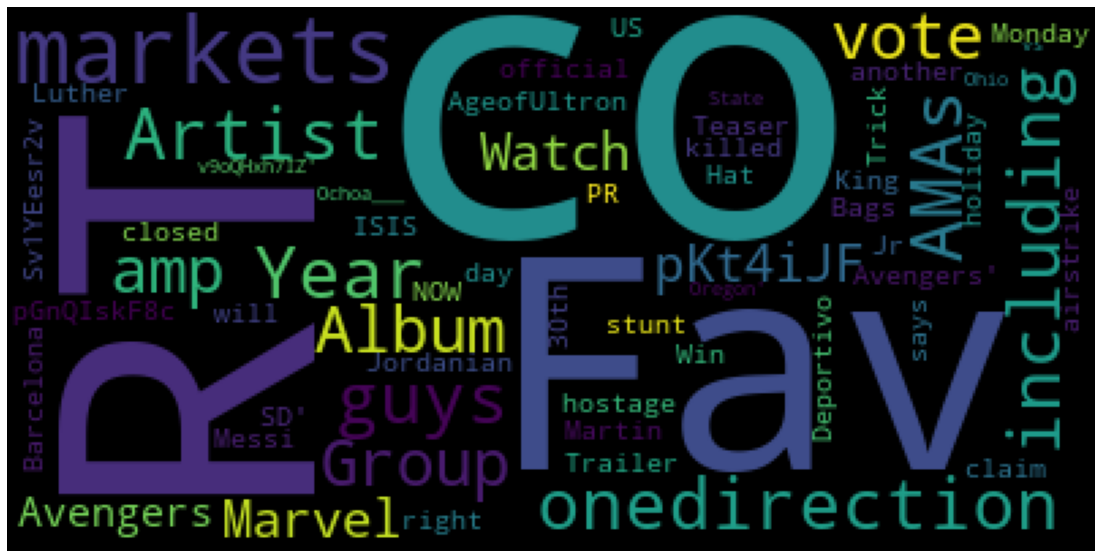

In [28]:
text = df['text'].values 

#Create a word cloud showing the most common words in the tweets
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

"RT" refers to re-tweet which makes sense that the majority of tweets would be referencing another

## Cleaning & Vectorizing

In [29]:
# Function to clean each text string
def cleaning(text):

    #lowercase all characters
    text = text.lower()
    
    #remove links
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    #Remove special characters
    text = re.sub('<.*>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    text = re.sub('[„»â€™]', '', text)
    
    #tokenize and re-join
    text_tokens = word_tokenize(text)
    filtered_sentence = (" ").join(text_tokens)
    text = filtered_sentence
    return text #return cleaned sentences

In [30]:
# Apply cleaning function to the testing and training data
X_train_c = X_train.apply(cleaning)
X_test_c = X_test.apply(cleaning)

In [31]:
X_train_c.head()

71638     apparently borderpatrol will be screening for ...
157778                     shit nigga age of ultron trailer
313229    rt davefox2 tony come on tjonessltrib i now ho...
241781    guardian news republicans win majority in us s...
323288    rt umakumaran thoughtful piece by chukaumunna ...
Name: text, dtype: object

In [32]:
# Vectorize X test and train with Term Frequency-Inverse Document Frequency (TFIDF)
tvec = TfidfVectorizer()
X_train_tv = tvec.fit_transform(X_train_c)
X_test_tv = tvec.transform(X_test_c)

## Initial Classification Model Evaluation

Primarily evaluating classification models with default settings

In [33]:
# Multinomial Bayes
mnb = MultinomialNB()
print('MNB')
print(f"CV score: {cross_val_score(mnb, X_train_tv, y_train, cv=5).mean()}")
mnb.fit(X_train_tv, y_train)
print(f"Train Score: {mnb.score(X_train_tv, y_train)}")
print(f"Test Score: {mnb.score(X_test_tv, y_test)}")

MNB
CV score: 0.9387928627334843
Train Score: 0.9538831793937818
Test Score: 0.9377586055110485


In [34]:
# Random Forest Classifier
rf = RandomForestClassifier()
print('Random Forest')
print(f"CV score: {cross_val_score(rf, X_train_tv, y_train, cv=5).mean()}")
rf.fit(X_train_tv, y_train)
print(f"Train Score: {rf.score(X_train_tv, y_train)}")
print(f"Test Score: {rf.score(X_test_tv, y_test)}")

Random Forest
CV score: 0.9722908684073831
Train Score: 0.9968995273405317
Test Score: 0.9725768113390263


In [35]:
# Bagging Classifier
bag = BaggingClassifier()
print('Bagging')
print(f"CV score: {cross_val_score(bag, X_train_tv, y_train, cv=5).mean()}")
bag.fit(X_train_tv, y_train)
print(f"Train Score: {bag.score(X_train_tv, y_train)}")
print(f"Test Score: {bag.score(X_test_tv, y_test)}")

Bagging
CV score: 0.9712067682515506
Train Score: 0.9948614544035385
Test Score: 0.972972972972973


In [36]:
# Ada Boost Classifier
ada = AdaBoostClassifier()
print('Ada')
print(f"CV score: {cross_val_score(ada, X_train_tv, y_train, cv=5).mean()}")
ada.fit(X_train_tv, y_train)
print(f"Train Score: {ada.score(X_train_tv, y_train)}")
print(f"Test Score: {ada.score(X_test_tv, y_test)}")

Ada
CV score: 0.9523871366554083
Train Score: 0.9537097263778674
Test Score: 0.952460603926402


In [37]:
# K Nearest Neighbors Classifier
knn = KNeighborsClassifier()
print('KNN')
print(f"CV score: {cross_val_score(knn, X_train_tv, y_train, cv=5).mean()}")
knn.fit(X_train_tv, y_train)
print(f"Train Score: {knn.score(X_train_tv, y_train)}")
print(f"Test Score: {knn.score(X_test_tv, y_test)}")

KNN
CV score: 0.8379733204530657
Train Score: 0.8814665452495555
Test Score: 0.8623118232238753


In [38]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
print('Decision Tree')
print(f"CV score: {cross_val_score(dt, X_train_tv, y_train, cv=5).mean()}")
dt.fit(X_train_tv, y_train)
print(f"Train Score: {dt.score(X_train_tv, y_train)}")
print(f"Test Score: {dt.score(X_test_tv, y_test)}")

Decision Tree
CV score: 0.9689952357112469
Train Score: 0.9969212089675209
Test Score: 0.9691874284708161


In [39]:
from sklearn.multiclass import OneVsRestClassifier
n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf.fit(X_train_tv, y_train)
print(f"CV score: {cross_val_score(clf, X_train_tv, y_train, cv=5).mean()}")
print(f"Train Score: {clf.score(X_train_tv, y_train)}")
print(f"Test Score: {clf.score(X_test_tv, y_test)}")

CV score: 0.9632713153150612
Train Score: 0.9698191752309093
Test Score: 0.9660181353992429


## Stemmer

In [40]:
# Creating a stemming function
# Choice of snowball as it imporves upon Porter but is not as strict as Lancaster
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english') 

analyzer = TfidfVectorizer().build_analyzer()

def stemmed_snow(doc):
    return (s_stemmer.stem(w) for w in analyzer(doc))

## Hyperparamter Tuning with GridSearchCV

In [68]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer( )),
    ('bag', BaggingClassifier())
])

In [99]:
pipe_params = {
     'tvec__max_features' : [5000], 
     'tvec__min_df' : [5], 
     'tvec__max_df' : [0.95],
     'tvec__analyzer' : [stemmed_snow], 
    
}

In [100]:
gs = GridSearchCV(pipe,param_grid = pipe_params, cv=3, verbose = 1, n_jobs = -1)

In [101]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bag', BaggingClassifier())]),
             n_jobs=-1,
             param_grid={'tvec__analyzer': [<function stemmed_snow at 0x7f866cb9fa70>],
                         'tvec__max_df': [0.95], 'tvec__max_features': [5000],
                         'tvec__min_df': [5]},
             verbose=1)

In [102]:
print(f"Best score: {gs.best_score_}")
gs_model = gs.best_estimator_
gs.best_params_

Best score: 0.9724860153505919


{'tvec__analyzer': <function __main__.stemmed_snow>,
 'tvec__max_df': 0.95,
 'tvec__max_features': 5000,
 'tvec__min_df': 5}

In [103]:
pred_ = gs.predict(X_test)
print(f"Train Score: {gs.score(X_train, y_train)}")
print(f"Test Score: {gs.score(X_test, y_test)}")

Train Score: 0.9941893239668704
Test Score: 0.9763623558411832


In [104]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_).ravel()
print(f"True Negatives: {tn}")
print(f"Fale Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print("")
Accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Accuracy: {Accuracy}")

True Negatives: 6249
Fale Positives: 382
False Negatives: 155
True Positives: 15932

Accuracy: 0.9763623558411832


TEST RESULTS
ACCURACY: 0.9763623558411832
F1 SCORE: 0.9834264374556341
ROC AUC: 0.9663783435074422


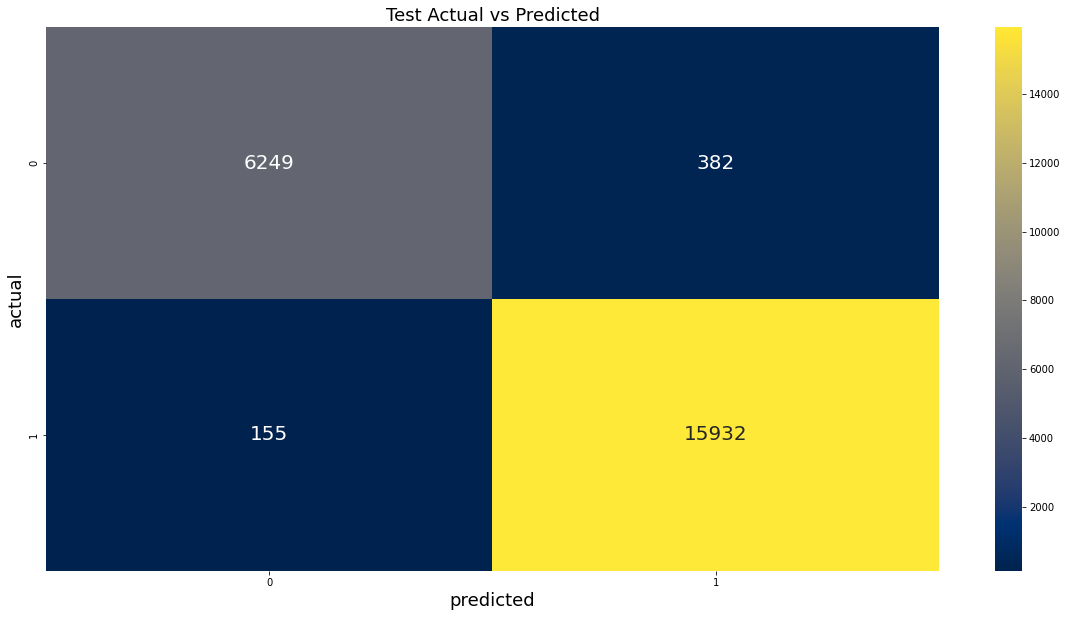

In [105]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Scores
f1 = f1_score(y_test, pred_)
roc_auc = roc_auc_score(y_test, pred_)
cm = confusion_matrix(y_test, pred_)

print('TEST RESULTS')
print(f'ACCURACY: {Accuracy}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()

## Save Model

In [81]:
import pickle

In [106]:
filename = 'finalized_model_bag.sav'
pickle.dump(gs, open(filename, 'wb'))

## Validation

In [107]:
val = pd.read_csv('validation_data.csv')

X_val = val['text']
y_val = val['is_credible']

In [108]:
# load the model from disk & put validation data through
filename = 'finalized_model_bag.sav'
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.score(X_val, y_val)
print(result)

0.8217821782178217


## Case Study: California Wildfires

In [109]:
cal = pd.read_csv('california_wildfires.csv')

X_cal = cal['text']
y_cal = cal['is_credible']

In [110]:
result = loaded_model.score(X_cal, y_cal)
print(result)

0.508
